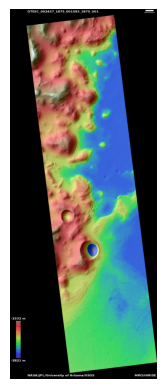

In [252]:
Product_ID = 'DTEPC_009400_2685_009359_2715_A01'
Product_ID = 'DTEEC_002478_1365_003678_1365_U01'
Product_ID = 'DTEEC_002437_1875_001593_1875_U01'
# Product_ID = 'DTEED_022962_1570_022672_1570_A01'
# Product_ID = 'DTEEC_016509_1980_016575_1980_U01'
# Product_ID = 'DTEED_018738_1585_019160_1585_A01'
img_path = 'data/DTM/' + Product_ID + '.IMG'
jpg_path = 'data/JPG/' + Product_ID + '.ca.jpg'
# 显示jpg
from PIL import Image
from matplotlib import pyplot as plt

img = Image.open(jpg_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [253]:
from osgeo import gdal
import numpy as np

dataset = gdal.Open(img_path, gdal.GA_ReadOnly)
# 读取数据
data = dataset.ReadAsArray()
# 获取数据信息
print('Driver: ', dataset.GetDriver().ShortName, '/', dataset.GetDriver().LongName)
print('Size is ', dataset.RasterXSize, 'x', dataset.RasterYSize, 'x', dataset.RasterCount)
print('Projection is ', dataset.GetProjection())
geotransform = dataset.GetGeoTransform()
if not geotransform is None:
    print('Origin = (', geotransform[0], ',', geotransform[3], ')')
    print('Pixel Size = (', geotransform[1], ',', geotransform[5], ')')
# ignore_value
ignore_value = dataset.GetRasterBand(1).GetNoDataValue()
print('ignore_value: ', ignore_value)

Driver:  PDS / NASA Planetary Data System
Size is  8043 x 22091 x 1
Projection is  PROJCS["EQUIRECTANGULAR MARS",GEOGCS["GCS_MARS",DATUM["D_MARS",SPHEROID["MARS_localRadius",3396036.8126024,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",5],PARAMETER["central_meridian",151.91],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Origin = ( -4344.585040267033 , 437326.23361672834 )
Pixel Size = ( 1.011544828933 , -1.011544828933 )
ignore_value:  -3.4028226550889045e+38


In [254]:
# ignore_value用NAN替代
data[data == ignore_value] = np.NAN
# 划分方格
data_mask = np.isnan(data)
center = [int(data_mask.shape[0] / 2), int(data_mask.shape[1] / 2)]
# 取出最大区域全为true的区域
count = 1
while True:
    if np.all(data_mask[center[0] - count: center[0] + count + 1, center[1] - count: center[1] + count + 1] == False):
        count += 1
    else:
        count -= 1
        break
center_index = count

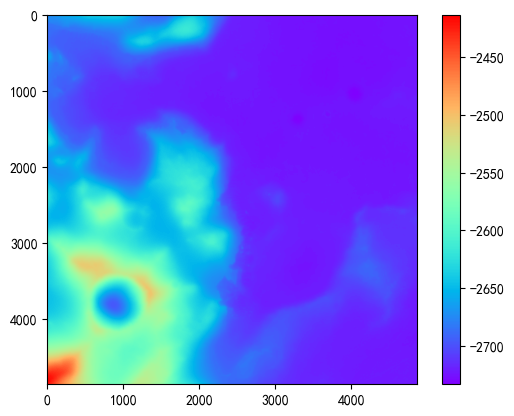

In [255]:
data_cut = data[center[0] - count: center[0] + count + 1, center[1] - count: center[1] + count + 1]
plt.imshow(data_cut, cmap='rainbow')
plt.colorbar()

In [256]:
geotransform = dataset.GetGeoTransform()
if abs(geotransform[1]) != abs(geotransform[5]):
    print('warning: 两个方向上的距离间隔不一致')
map_scale = abs(geotransform[1])
actural_interval = 100  # m
interval = int(actural_interval / map_scale)
if interval % 2 == 0:
        interval = interval + 1

In [257]:
from numpy.fft import fft,ifft,fftshift,ifftshift
def filter_1d_fft(dem,_interval):
    filter_dem = np.pad(dem, (_interval, _interval), 'edge')
    _filter_kernel = np.ones(_interval) / _interval
    _filter_pad_size = int((filter_dem.shape[0] - _interval)/2)
    _filter_kernel = np.pad(_filter_kernel, (_filter_pad_size, _filter_pad_size), 'constant')
    
    filter_dem_fft = fft(filter_dem)
    filter_kernel_fft = fft(_filter_kernel)
    
    filtered_result = filter_dem_fft * filter_kernel_fft
    
    filtered_result = fftshift(ifft(filtered_result)).real
    
    big_scale_dem = filtered_result[interval:-interval]
    small_scale_dem = dem - big_scale_dem
    return big_scale_dem,small_scale_dem

from numpy.fft import fft2,ifft2
def filter_2d_fft(dem, _interval):
    # 对数据进行零填充，以便与滤波器核进行卷积
    padded_dem = np.pad(dem, ((_interval, _interval), (_interval, _interval)), 'edge')
    
    # 生成滤波器核，并对其进行零填充以匹配输入数据的尺寸
    _filter_kernel = np.ones((_interval, _interval)) / (_interval ** 2)
    _filter_pad_size = int((padded_dem.shape[0]-_interval)/2)
    padded_kernel = np.pad(_filter_kernel, ((_filter_pad_size, _filter_pad_size), (_filter_pad_size, _filter_pad_size)), 'constant')
    
    # 计算输入数据和滤波器核的二维傅里叶变换
    dem_fft = fft2(padded_dem)
    kernel_fft = fft2(padded_kernel)
    
    # 频域相乘
    result_fft = dem_fft * kernel_fft
    
    # 逆二维傅里叶变换回到空间域
    filtered_result = fftshift(ifft2(result_fft)).real
    
    # 截取有效部分
    big_scale_dem = filtered_result[_interval:-_interval, _interval:-_interval]
    
    # 计算小尺度细节
    small_scale_dem = dem - big_scale_dem
    
    return big_scale_dem, small_scale_dem

bs_2d,ss_2d = filter_2d_fft(data_cut, interval)

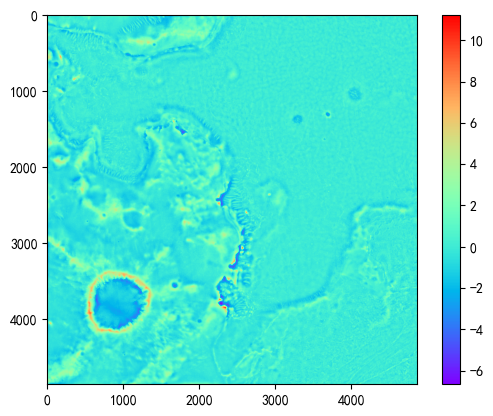

In [258]:
plt.imshow(ss_2d, cmap='rainbow')
plt.colorbar()
plt.show()

In [259]:
def RMSH(dem):
    dem_mean = np.nanmean(dem)
    rmsh = np.sqrt(np.nansum((dem - dem_mean) ** 2) / (np.sum(~np.isnan(dem)) - 1))
    return rmsh


rmsh_1d = np.zeros(data_cut.shape[0])
for i in range(data_cut.shape[0]):
    bs_1d, ss_1d = filter_1d_fft(data_cut[i, :], interval)
    rmsh_1d[i] = RMSH(ss_1d)
rmsh_2d = RMSH(ss_2d)
print(np.mean(rmsh_1d), rmsh_2d)

0.5386333306867273 0.8563492512623032


In [260]:
from numpy.fft import fft, ifft, fftshift
def autocorrelation_1d(_dem):
    _mean_1d = np.mean(_dem)
    _Var_1d_1 = np.sum((_dem-_mean_1d) ** 2)
    _pad_size = int(_dem.shape[0] / 2)
    _expanded_ss_1d = np.pad(_dem - _mean_1d, _pad_size, 'constant')
    _fft_1d = fft(_expanded_ss_1d)
    _fft_1d_conj = np.conj(_fft_1d)
    _F_prod = _fft_1d * _fft_1d_conj
    _rho_num = fftshift(ifft(_F_prod)).real
    _autocorrelation_1d = _rho_num[_pad_size:-_pad_size]/_Var_1d_1
    return _autocorrelation_1d[center_index:]
autocorrelation_1d_fft = np.zeros((data_cut.shape[0],center_index+1))
for i in range(data_cut.shape[0]):
    autocorrelation_1d_fft[i,:] = autocorrelation_1d(_dem=filter_1d_fft(data_cut[i,:],interval)[1])

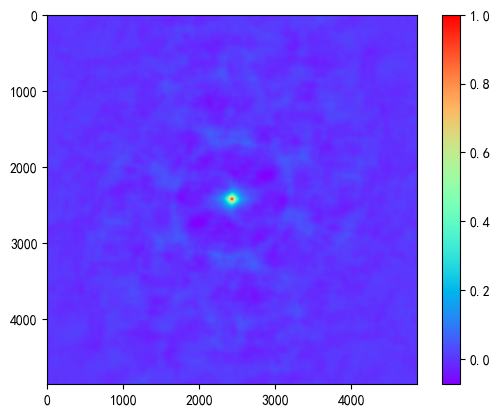

In [261]:
from numpy.fft import fft2, ifft2, fftshift
def autocorrelation_2d(_dem):
    _mean_2d = np.nanmean(_dem)
    _Var_2d_1 = np.sum((_dem-_mean_2d) ** 2)
    _pad_size = int(_dem.shape[0] / 2)
    _expanded_ss_2d = np.pad(_dem - _mean_2d, (_pad_size, _pad_size), 'constant')
    _fft_2d = fft2(_expanded_ss_2d)
    _fft_2d_conj = np.conj(_fft_2d)
    _F_prod = _fft_2d * _fft_2d_conj
    _rho_num = fftshift(ifft2(_F_prod)).real
    _autocorrelation_2d = _rho_num[_pad_size:-_pad_size, _pad_size:-_pad_size]/_Var_2d_1
    return _autocorrelation_2d

autocorrelation_2d_1 = autocorrelation_2d(ss_2d)
plt.imshow(autocorrelation_2d_1,cmap='rainbow')
plt.colorbar()
plt.show()

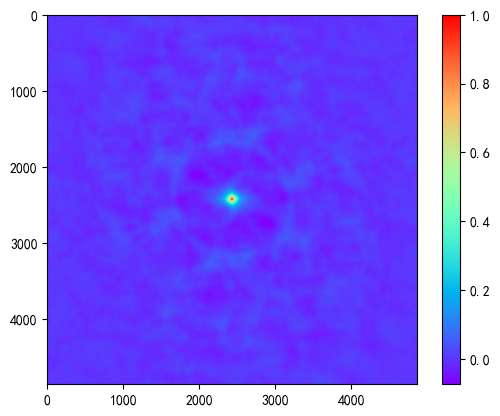

In [262]:
autocorrelation_2d_2 = autocorrelation_2d(np.flipud(ss_2d))
plt.imshow(autocorrelation_2d_2,cmap='rainbow')
plt.colorbar()
plt.show()

In [263]:
# autocorrelation_2d_1 = (autocorrelation_2d_1 + autocorrelation_2d_2) / 2

In [264]:
x = np.arange(-center_index, center_index + 1, 1) * map_scale
xx, yy = np.meshgrid(x, x)
distance_2d = np.sqrt(xx ** 2 + yy ** 2)

In [265]:
length = 300
up_percent = 90
med_percent = 50
down_percent = 10
#1D
x_data_1d = np.arange(0,length,1)*map_scale
ar_up_1d = np.percentile(autocorrelation_1d_fft[:,:length],up_percent,axis=0)
ar_med_1d = np.percentile(autocorrelation_1d_fft[:,:length],med_percent,axis=0)
ar_down_1d = np.percentile(autocorrelation_1d_fft[:,:length],down_percent,axis=0)

#2D
distance_2d_flatten = distance_2d.flatten()
autocorrelation_2d_1_flatten = autocorrelation_2d_1.flatten()
# autocorrelation_2d_1_flatten根据distance_2d_flatten排序
sorted_index = np.argsort(distance_2d_flatten)
distance_2d_flatten = distance_2d_flatten[sorted_index]
autocorrelation_2d_1_flatten = autocorrelation_2d_1_flatten[sorted_index]
# autocorrelation_2d_1_flatten按照map_scale的距离进行分类
distance_2d_flatten_unique = np.unique(distance_2d_flatten)
# 剔除distance大于length*map_scale的点
distance_2d_flatten_unique = distance_2d_flatten_unique[distance_2d_flatten_unique <= length * map_scale]
delta = np.arange(0, length, 1) * map_scale
distance_2d_flatten_list = []
autocorrelation_2d_1_flatten_list = []
for i in range(len(delta) - 1):
    distance_2d_flatten_list.append(
        distance_2d_flatten[(distance_2d_flatten >= delta[i]) & (distance_2d_flatten < delta[i + 1])])
    autocorrelation_2d_1_flatten_list.append(
        autocorrelation_2d_1_flatten[(distance_2d_flatten >= delta[i]) & (distance_2d_flatten < delta[i + 1])])
x_data_2d = np.arange(0, len(distance_2d_flatten_list), 1) * map_scale

# autocorrelation_2d_1_flatten_list每一行求percentiles, 得到80,50,15的分位数
ar_up_list = []
ar_med_list = []
ar_down_list = []
for i in range(len(autocorrelation_2d_1_flatten_list)):
    ar_up_list.append(np.percentile(autocorrelation_2d_1_flatten_list[i], up_percent))
    ar_med_list.append(np.percentile(autocorrelation_2d_1_flatten_list[i], med_percent))
    ar_down_list.append(np.percentile(autocorrelation_2d_1_flatten_list[i], down_percent))

ar_up_2d = np.array(ar_up_list)
ar_med_2d = np.array(ar_med_list)
ar_down_2d = np.array(ar_down_list)

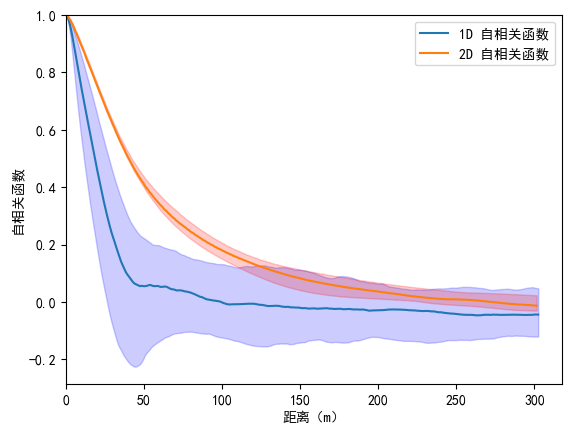

In [266]:
# 中文支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(x_data_1d,ar_med_1d,label='1D 自相关函数')
plt.fill_between(x_data_1d,ar_down_1d,ar_up_1d,alpha=0.2,color='blue')
plt.plot(x_data_2d,ar_med_2d,label='2D 自相关函数')
plt.fill_between(x_data_2d,ar_down_2d,ar_up_2d,alpha=0.2,color='red')
plt.legend()
plt.ylim(top=1)
plt.xlim(left=0)

# y轴标签
plt.ylabel('自相关函数')
# x轴标签
plt.xlabel('距离（m）')

# 保存
plt.savefig('Paper/2-19/' + Product_ID + '_autocorrelation.png', dpi=300, bbox_inches='tight')

1064
el: 0.4303477155432448


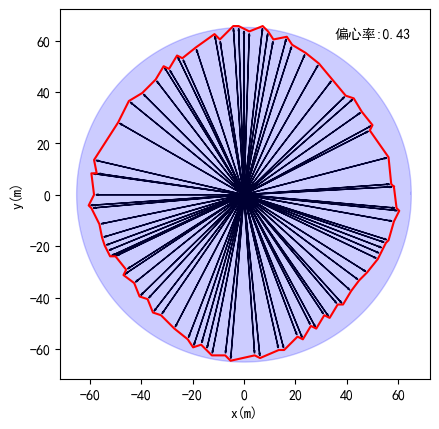

In [273]:
crol_2d = autocorrelation_2d_1 - 1/np.e
# 找到corl_2d接近于零+-0.05的点的位置，用scatter函数画出来
index_crol_2d = np.where(np.abs(crol_2d) < 0.01)

# 计算l
distance_index_crol_2d = distance_2d[index_crol_2d]

arrow_max = 80
# 转化为ndarry
index_crol_2d = ((np.array(index_crol_2d) - center_index) * map_scale)
# 偏心度计算
el = np.sqrt(1-(np.min(distance_index_crol_2d)/np.max(distance_index_crol_2d)))

print(index_crol_2d.shape[1])
if arrow_max > index_crol_2d.shape[1]:
    print('arrow_max大于index_crol_2d的长度，无法进行缩放,长度为：',index_crol_2d.shape[1])
else:
    if arrow_max == 0:
        pass
    else:
        step = int(index_crol_2d.shape[1]/arrow_max)
        if step >= 0:
            index_crol_2d = index_crol_2d[:,::step]
ac_l = np.sqrt(index_crol_2d[0,:]**2 + index_crol_2d[1,:]**2)
# 用箭头画出index_crol_2d的位置
for i in range(index_crol_2d.shape[1]):
    plt.arrow(0,0,index_crol_2d[0,i],index_crol_2d[1,i],head_width=0.5,head_length=1,fc='k',ec='k')
# 计算index_crol_2d的角度，使得按照逆时针方向画出index_crol_2d的位置点的连线
angle_crol_2d = np.arctan2(index_crol_2d[1,:],index_crol_2d[0,:])
# 按照angle_crol_2d的值和index_crol_2d中x的正负值，画出index_crol_2d的位置点的连线
# 为了按顺时针排序，我们需要将角度调整到 [0, 2*pi)
angle_crol_2d = np.mod(angle_crol_2d, 2 * np.pi)
 
# 按角度排序
sorted_indices = np.argsort(angle_crol_2d)
sorted_points = index_crol_2d[:, sorted_indices]
sorted_points = np.append(sorted_points, sorted_points[:, 0].reshape(2,1),axis=1)
yanchang = 1.03

max_l = np.max(np.sqrt(index_crol_2d[0,:]**2 + index_crol_2d[1,:]**2)) + 1

# 归一化sorted_points，并乘以max_l
# out_points = sorted_points/ np.linalg.norm(sorted_points, axis=0) * max_l
# 初始化从0°到360°的单位向量，间隔为1°
out_points = np.zeros((2, 360))
# 生成从0°到360°的角度
angles = np.linspace(0, (2+1/180) * np.pi, 360)
# 计算单位向量
out_points[0, :] = np.cos(angles)
out_points[1, :] = np.sin(angles)
# 将单位向量乘以max_l
out_points = out_points * max_l
# 画出按顺序连接的线
plt.plot(sorted_points[0, :] * yanchang, sorted_points[1, :]* yanchang, 'r-')



plt.fill(out_points[0, :], out_points[1, :], alpha=0.2, color='blue')
# x和y轴缩放相同
plt.axis('equal')
# 长宽相同
plt.axis('square')
# x轴标签
plt.xlabel('x(m)')
# y轴标签
plt.ylabel('y(m)')
# 显示偏心率，在右上角
plt.text(0.95, 0.95, '偏心率:{:.2f}'.format(el), horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)

# 保存
plt.savefig('Paper/2-19/' + Product_ID + '_autocorrelation_arrow.png', dpi=300, bbox_inches='tight')

print('el:',el)

In [268]:
# 偏心度计算


In [269]:
from scipy.optimize import curve_fit
# 忽略除以0的报错
np.seterr(divide='ignore', invalid='ignore')

def gaussian(x, A, x0, sigma):
    return A * np.exp(-(x - x0)**2 / (2 * sigma**2))

def exponential(x, A, lambda_):
    return A * np.exp(-lambda_ * x)

def modulated_exponential(x, A, B, lambda_):
    return A * np.cos(B * x) * np.exp(-lambda_ * x)

# 使用 curve_fit 来找到最佳拟合参数
popt, _ = curve_fit(modulated_exponential, x_data_1d, ar_med_1d,p0=None,bounds=([0,-np.inf,0],[np.inf,np.inf,np.inf]),maxfev=10000)
# popt包含拟合的参数A, x0, sigma, B
_A, _B, _lambda_ = popt
y_modulated_exponential = modulated_exponential(x_data_1d, _A, _B,_lambda_)

popt, _ = curve_fit(gaussian, x_data_1d, ar_med_1d,p0=None,bounds=([0,-np.inf,0],[np.inf,np.inf,np.inf]),maxfev=10000)
A, omega, lambda_ = popt
y_gaussian = gaussian(x_data_1d, A, omega,lambda_)

popt, _ = curve_fit(exponential, x_data_1d, ar_med_1d,p0=None,bounds=([0,0],[np.inf,np.inf]))
A, lambda_ = popt
y_exponential = exponential(x_data_1d, A, lambda_)

gaussian_r2: 0.981211133445935
exponential_r2: 0.9741037796260847
modulated_exponential_r2: 0.9776472332143631
gaussian_mse: 0.0008055572200970802
exponential_mse: 0.0011102791770544178
modulated_exponential_mse: 0.0009583565150937892


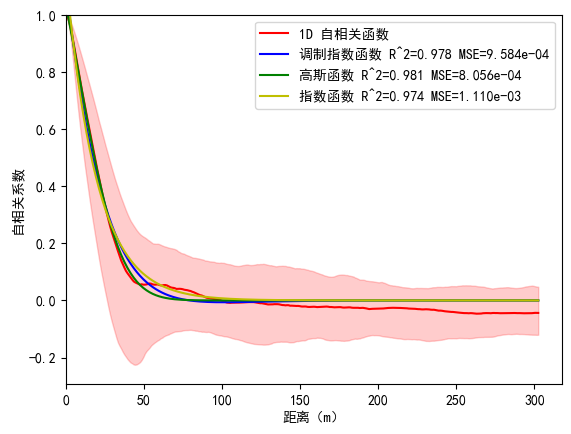

In [270]:
# 计算拟合效果R^2和MSE
from sklearn.metrics import r2_score
modulated_exponential_r2 = r2_score(ar_med_1d, y_modulated_exponential)
gaussian_r2 = r2_score(ar_med_1d, y_gaussian)
exponential_r2 = r2_score(ar_med_1d, y_exponential)
print('gaussian_r2:',gaussian_r2)
print('exponential_r2:',exponential_r2)
print('modulated_exponential_r2:',modulated_exponential_r2)
from sklearn.metrics import mean_squared_error
modulated_exponential_mse = mean_squared_error(ar_med_1d, y_modulated_exponential)
gaussian_mse = mean_squared_error(ar_med_1d, y_gaussian)
exponential_mse = mean_squared_error(ar_med_1d, y_exponential)
print('gaussian_mse:',gaussian_mse)
print('exponential_mse:',exponential_mse)
print('modulated_exponential_mse:',modulated_exponential_mse)



plt.plot(x_data_1d,ar_med_1d,color = 'r',label='1D 自相关函数')
plt.fill_between(x_data_1d,ar_down_1d,ar_up_1d,alpha=0.2,color='red')
plt.plot(x_data_1d,y_modulated_exponential,color = 'b',label='调制指数函数 R^2=%.3f MSE=%.3e' % (modulated_exponential_r2,modulated_exponential_mse))
plt.plot(x_data_1d,y_gaussian,color = 'g',label='高斯函数 R^2=%.3f MSE=%.3e' % (gaussian_r2,gaussian_mse))
plt.plot(x_data_1d,y_exponential,color = 'y',label='指数函数 R^2=%.3f MSE=%.3e' % (exponential_r2,exponential_mse))
plt.ylim(top=1)
plt.xlim(left=0)
plt.legend()
# x轴标签
plt.xlabel('距离（m）')
# y轴标签
plt.ylabel('自相关系数')
# 保存
plt.savefig('Paper/2-19/' + Product_ID + '_autocorrelation_1d.png', dpi=300, bbox_inches='tight')

In [271]:
# 使用 curve_fit 来找到最佳拟合参数
popt, _ = curve_fit(modulated_exponential, x_data_2d, ar_med_2d,p0=None,bounds=([0,-np.inf,0],[np.inf,np.inf,np.inf]),maxfev=1000)
# popt包含拟合的参数A, x0, sigma, B
_A, _B, _lambda_ = popt
y_modulated_exponential = modulated_exponential(x_data_2d, _A, _B,_lambda_)

popt, _ = curve_fit(gaussian, x_data_2d, ar_med_2d,p0=None,bounds=([0,-np.inf,0],[np.inf,np.inf,np.inf]),maxfev=100000)
A, omega, lambda_ = popt
y_gaussian = gaussian(x_data_2d, A, omega,lambda_)

popt, _ = curve_fit(exponential, x_data_2d, ar_med_2d,p0=None,bounds=([0,0],[np.inf,np.inf]))
A, lambda_ = popt
y_exponential = exponential(x_data_2d, A, lambda_)

gaussian_r2: 0.9981528789386156
exponential_r2: 0.998183515064279
modulated_exponential_r2: 0.9981835149311659
gaussian_mse: 0.00012106390703154985
exponential_mse: 0.00011905595576800945
modulated_exponential_mse: 0.00011905596449250495


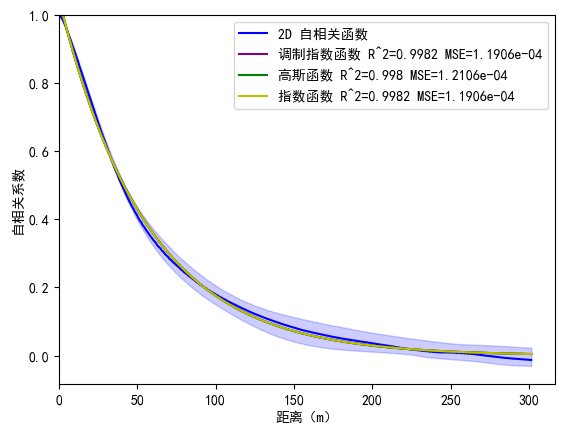

In [272]:
# 计算拟合效果R^2和MSE
from sklearn.metrics import r2_score
modulated_exponential_r2 = r2_score(ar_med_2d, y_modulated_exponential)
gaussian_r2 = r2_score(ar_med_2d, y_gaussian)
exponential_r2 = r2_score(ar_med_2d, y_exponential)
print('gaussian_r2:',gaussian_r2)
print('exponential_r2:',exponential_r2)
print('modulated_exponential_r2:',modulated_exponential_r2)
from sklearn.metrics import mean_squared_error
modulated_exponential_mse = mean_squared_error(ar_med_2d, y_modulated_exponential)
gaussian_mse = mean_squared_error(ar_med_2d, y_gaussian)
exponential_mse = mean_squared_error(ar_med_2d, y_exponential)
print('gaussian_mse:',gaussian_mse)
print('exponential_mse:',exponential_mse)
print('modulated_exponential_mse:',modulated_exponential_mse)

plt.plot(x_data_2d,ar_med_2d,color = 'b',label='2D 自相关函数')
plt.fill_between(x_data_2d,ar_down_2d,ar_up_2d,alpha=0.2,color='b')
plt.plot(x_data_2d,y_modulated_exponential,color = 'purple',label='调制指数函数 R^2=%.4f MSE=%.4e' % (modulated_exponential_r2,modulated_exponential_mse))
plt.plot(x_data_2d,y_gaussian,color = 'g',label='高斯函数 R^2=%.3f MSE=%.4e' % (gaussian_r2,gaussian_mse))
plt.plot(x_data_2d,y_exponential,color = 'y',label='指数函数 R^2=%.4f MSE=%.4e' % (exponential_r2,exponential_mse))
plt.ylim(top=1)
plt.xlim(left=0)
plt.legend()
# x轴标签
plt.xlabel('距离（m）')
# y轴标签
plt.ylabel('自相关系数')
# 保存
plt.savefig('Paper/2-19/' + Product_ID + '_autocorrelation_2d.png', dpi=300, bbox_inches='tight')